### Разведочный анализ конкурсных рассказов с платформы "AuthorToday"
Задача данного исследования заключалась в проверке, существует ли зависимость между оценкой художественного текста от  его базовыми количественными, а также частотными характеристиками. Оценка выражена либо в непосредственной оценке от 1 до 11 баллов, либо в соотношении лайков, поставленных читателями, к общему количеству простмотров. 
В качестве факторов были взяты только основные количественные (длины слов, предложений, абзацев) характеристики, а также частотность частей речи. Семантическая составляющая текста не учитывалась.

#### Импорт необходимых библиотек

In [1]:
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from pymorphy2 import MorphAnalyzer
%matplotlib inline

#### Загрузим и рассмотрим датасет

In [2]:
dataset = pd.read_json('final_results.json')

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295 entries, 0 to 294
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   index            295 non-null    int64 
 1   title            295 non-null    object
 2   href             295 non-null    object
 3   access           295 non-null    object
 4   text_url         295 non-null    object
 5   likes            295 non-null    int64 
 6   views            295 non-null    int64 
 7   comments_number  295 non-null    int64 
 8   comment_urls     295 non-null    object
 9   grades           295 non-null    object
 10  text             295 non-null    object
dtypes: int64(4), object(7)
memory usage: 25.5+ KB


In [4]:
dataset.head()

,index,title,href,access,text_url,likes,views,comments_number,comment_urls,grades,text
0,1,На часах 14:15,https://author.today/work/53594,Свободный,https://author.today/reader/53594,25,885,52,[?page=1&sorting=reverse#comments],"[4, 5, 9, 3, 9, 1, 3, 9, 3, 2, 11]","[На часах 14:15, - Сеть пропала, - цокнула язы..."
1,2,Парящая: Небесный патруль,https://author.today/work/53595,Свободный,https://author.today/reader/53595,20,880,41,[?page=1&sorting=reverse#comments],"[2, 2, 11, 6, 8, 3, 5, 6, 1, 3, 7, 2, 11, 9, 6...","[Парящая: Небесный патруль, Мне всегда было ин..."
2,3,Код Манны,https://author.today/work/53719,Свободный,https://author.today/reader/53719,3,1051,20,[?page=1&sorting=reverse#comments],"[10, 11, 8, 3, 11, 7, 10, 11, 11, 9, 11]","[Код Манны, «Неудачница», «Бездарная», «Уродин..."
3,4,Спасение,https://author.today/work/45769,Свободный,https://author.today/reader/45769,57,3030,49,"[?page=1&sorting=reverse#comments, ?page=2&sor...","[3, 6, 5, 1, 2, 6, 1, 4, 2, 5, 1, 9, 2, 11, 11...","[Спасение, Фантастический рассказ ""Спасение"", ..."
4,5,Маг по особым поручениям,https://author.today/work/53049,Свободный,https://author.today/reader/53049,34,1392,168,"[?page=1&sorting=reverse#comments, ?page=2&sor...","[2, 3, 1, 9, 4, 6, 5, 6, 10, 6]","[Маг по особым поручениям, – Ваши документы, м..."


Каждая запись в датасете содержит данные, собранные со страницы определенного конкурсного рассказа на author.today с помощью скрапера на основе BeautifulSoup4. Данные следующие: 
* название рассказа, 
* ссылка на страницу рассказа
* тип доступа к рассказу
* прямая ссылка на текст
* количество лайков
* количество просмотров
* количество комментариев
* ссылка на страницу комментариев
* оценки жюри конкурса в виде списка целых чисел
* текст рассказа в виде списка строк - по строке на каждый абзац.

Часть данных, таких как ссылки, название и тип доступа нам не понадобятся.
#### Удалим ненужные столбцы и добавим новые, содержащие рейтинг текста, вычисленный на основе оценок жюри, а также процент лайков относительно количества просмотров.

In [5]:
dataset.drop(columns = ['href', 'access', 'text_url', 'comment_urls', 'title'], inplace = True)

In [6]:
dataset['mean_grade'] = dataset['grades'].apply(lambda x: sum(x) / len(x))
dataset['median_grade'] = dataset['grades'].apply(np.median)
dataset['viewers_liked'] = dataset.apply(lambda row: row['likes'] / row['views'] * 100, axis = 1)

#### Посмотрим, как средняя оценка жюри соотносится с процентом лайков.

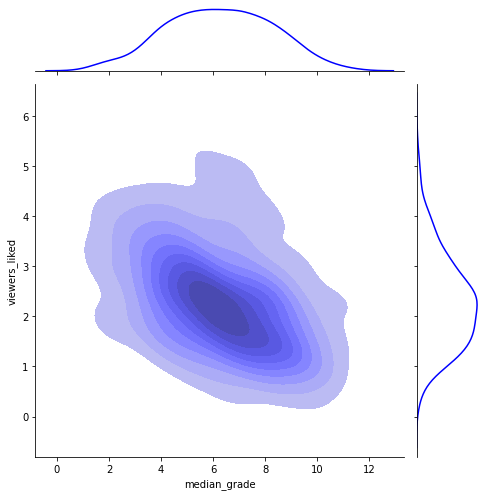

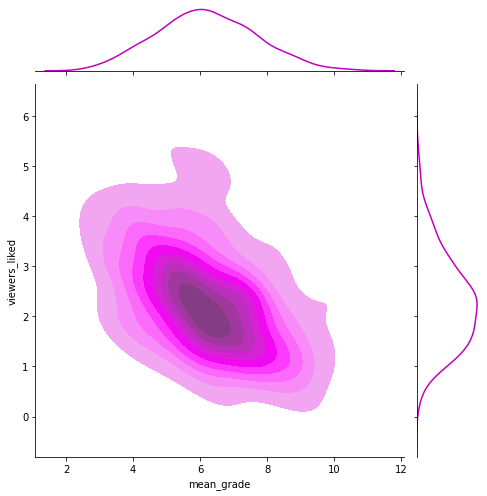

In [7]:
sns.jointplot(x = dataset['median_grade'], y = dataset['viewers_liked'], height = 7, color = 'b', 
              shade = True, kind = 'kde')
sns.jointplot(x = dataset['mean_grade'], y = dataset['viewers_liked'], height = 7, color = 'm', 
              shade = True, kind = 'kde')

Похоже, что рассказы с более высокой средней оценкой жюри в среднем получали меньше лайков от читателей. Это может быть связано с тем, что преимущественно высокая или низкая оценка жюри могла вызвать соответственно завышенные или заниженные ожидания у читателей. В дальнейшем, если текст не оправдывал создавшиеся у читателей ожидания, они могли быть соответственно менее или более склонны поставить рассказу лайк.

Чтобы проверить соотношение между средней оценкой жюри и процентом лайков читателей, мы можем рассмотреть распределение процента лайков для рассказов, сгруппированных по преобладающей оценке жюри. В этом случае медианная оценка жюри используется как категориальная переменная.

In [8]:
pd.unique(dataset['median_grade'])

array([ 4. ,  7. , 10. ,  5. ,  5.5,  8. ,  6. ,  4.5, 11. ,  2. ,  6.5,
        7.5,  3.5,  8.5,  9. ,  3. ,  9.5,  1.5])

<AxesSubplot:xlabel='median_grade', ylabel='viewers_liked'>

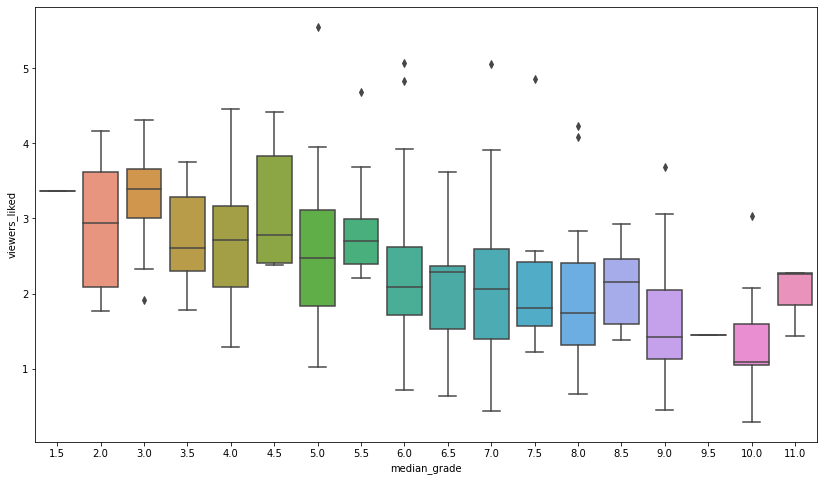

In [9]:
plt.figure(figsize = (14, 8))
sns.boxplot(x = dataset['median_grade'],
           y = dataset['viewers_liked'])

Существует вероятность, что рассказы с большей средней оценкой могли иметь большее число читательских просмотров, из-за чего при равном количестве лайков имели меньший их процент.
Посмотрим распределения для количества просмотров.

<AxesSubplot:xlabel='median_grade', ylabel='views'>

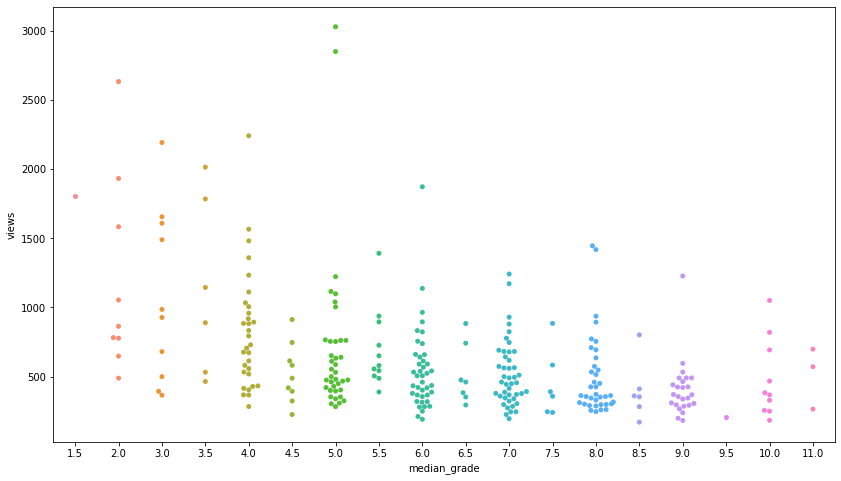

In [10]:
plt.figure(figsize = (14, 8))
sns.swarmplot(x = dataset['median_grade'],
           y = dataset['views'])

Как можно видеть, распределение просмотров скорее противоположное - у высоко оцененных рассказов диапазон числа просмотров меньше и смещен к более низким значениям.

<AxesSubplot:xlabel='mean_grade', ylabel='viewers_liked'>

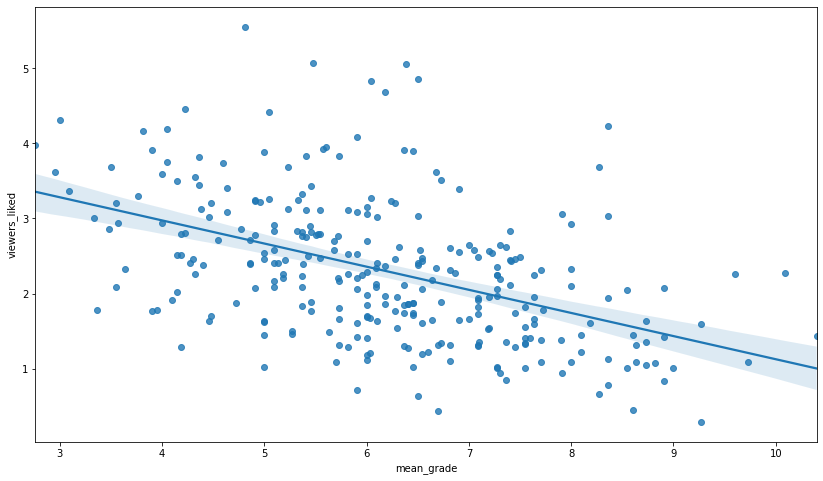

In [11]:
plt.figure(figsize = (14, 8))
sns.regplot(x = dataset['mean_grade'], y = dataset['viewers_liked'])

Прямая зависимости между процентом лайков и оценкой жюри, построенная посредством линейной регрессии, также указывает на то, что ниже оцененные рассказы имеют больший процент лайков.

#### Проверим распределения для оценок жюри и процента лайков.

<AxesSubplot:ylabel='viewers_liked'>

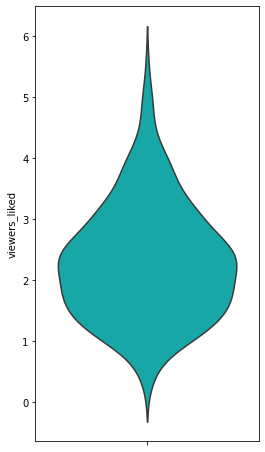

In [12]:
plt.figure(figsize = (4, 8))
sns.violinplot(y = dataset['viewers_liked'], inner = None, color = 'c')

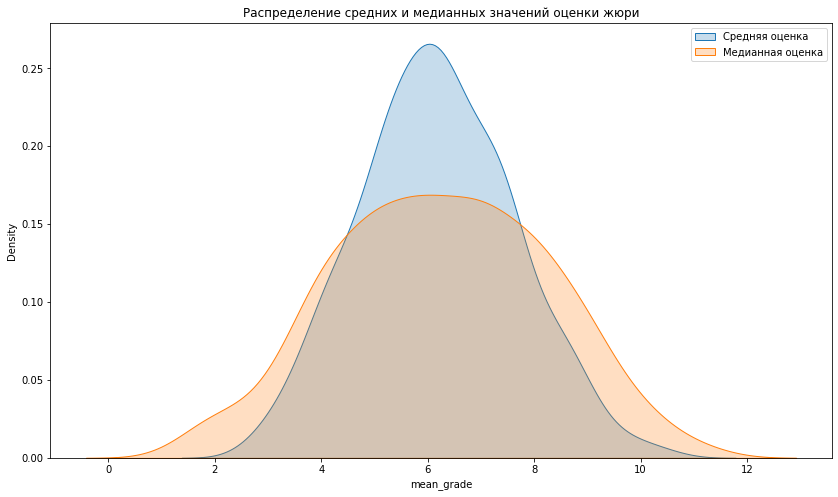

In [13]:
plt.figure(figsize = (14, 8))
sns.kdeplot(data = dataset['mean_grade'], label = 'Средняя оценка', shade = True)
sns.kdeplot(data = dataset['median_grade'], label = 'Медианная оценка', shade = True)
plt.title('Распределение средних и медианных значений оценки жюри')
plt.legend()

Процент пользовательских лайков немного смещен в сторону более низких значений, но все еще близок к нормальному распределению. Средняя оценка жюри соответствует нормальном распределению.
### Добавим функции для определения базовых количественных характеритик текста.
Сперва нам понядобятся две служебные функции:
* для разбиения абзацев на предложения
* для разбиения предложений на отдельные слова

Используя эти функции, вычислим среднюю длину слова (в символах), предложения и абзаца (в словах) для каждого текста и проверим, как они коррелируют с оценками текста.

In [14]:
#Разбиение абзаца на предложения.
def cut_to_sent(text):
    sentences = re.findall(r'[^.]+[.!?]', text)
    if sentences:
        return sentences
    else:
        return [text]

#Разбиение предложения на слова.
def cut_to_words(sent):
    words = re.split(r'[,;:-]\W|\W', sent)
    return [word for word in words if word]

#Поиск среднего или медианного значения длины слова для заданного текста.
def word_mean_median(text, metric = 'mean'):
    if isinstance(text, list):
        sentences = cut_to_sent(' '.join(text))
    else:
        sentences = cut_to_sent(text)
    lengths = []
    for sent in sentences:
        lengths.extend([len(word) for word in cut_to_words(sent)])
    if metric == 'median':
        return np.median(lengths)
    else:
        return np.mean(lengths)

#Поиск среднего или медианного значения длины предложения для заданного текста.
def sentence_mean_median(text, metric = 'mean'):
    if isinstance(text, list):
        sentences = cut_to_sent(' '.join(text))
    else:
        sentences = cut_to_sent(text)
    lengths = []
    for sent in sentences:
        lengths.append(len(cut_to_words(sent)))
    if metric == 'median':
        return np.median(lengths)
    else:
        return np.mean(lengths)

#Поиск среднего или медианного значения длины абзаца для заданного текста.
def paragraph_mean_median(pars, metric = 'mean'):
    lengths = []
    for par in pars:
        length_words = 0
        for sentence in cut_to_sent(par):
            length_words += len(cut_to_words(sentence))
        lengths.append(length_words)
    if metric == 'median':
        return np.median(lengths)
    else:
        return np.mean(lengths)

Создадим новый датафрейм, содержащий вышеуказанные характеристики.


In [15]:
len_set = dataset[['mean_grade', 'median_grade', 'viewers_liked', 'text']].copy()
len_set['mean_word_length'] = len_set['text'].apply(word_mean_median)
len_set['median_word_length'] = len_set['text'].apply(lambda x: word_mean_median(x, 'median'))
len_set['mean_sentence_length'] = len_set['text'].apply(sentence_mean_median)
len_set['median_sentence_length'] = len_set['text'].apply(lambda x: sentence_mean_median(x, 'median'))
len_set['mean_paragraph_length'] = len_set['text'].apply(paragraph_mean_median)
len_set['median_paragraph_length'] = len_set['text'].apply(lambda x: paragraph_mean_median(x, 'median'))

In [16]:
len_set.head()

,mean_grade,median_grade,viewers_liked,text,mean_word_length,median_word_length,mean_sentence_length,median_sentence_length,mean_paragraph_length,median_paragraph_length
0,5.363636,4.0,2.824859,"[На часах 14:15, - Сеть пропала, - цокнула язы...",5.576987,6.0,7.268687,7.0,13.976562,11.0
1,6.863636,7.0,2.272727,"[Парящая: Небесный патруль, Мне всегда было ин...",5.442478,5.0,12.421986,11.0,29.637931,12.0
2,9.272727,10.0,0.285442,"[Код Манны, «Неудачница», «Бездарная», «Уродин...",4.968131,5.0,8.903581,8.0,60.364486,60.0
3,5.454545,5.0,1.881188,"[Спасение, Фантастический рассказ ""Спасение"", ...",5.050151,5.0,8.803191,8.0,22.326389,10.5
4,5.200000,5.5,2.442529,"[Маг по особым поручениям, – Ваши документы, м...",5.503785,5.0,11.060465,10.0,20.539823,10.0


In [17]:
len_set[['mean_word_length', 'mean_sentence_length', 'mean_paragraph_length']].describe()

,mean_word_length,mean_sentence_length,mean_paragraph_length
count,295.000000,295.000000,295.000000
mean,5.366944,11.576963,27.036181
std,0.269880,2.397597,11.945487
min,4.692995,5.850746,6.865625
25%,5.191784,9.960337,19.666321
50%,5.348303,11.326667,24.578947
75%,5.540899,12.764065,31.543889
max,6.339759,22.526515,116.893617


Диапазон средних длин слов очень мал. Вряд ли этот параметр может оказывать заметное влияние на читательское восприятие всего текста. Рассмотрим графики распределения величин для всех трех характеристик.

Распределения значений базовых характеристик текста:


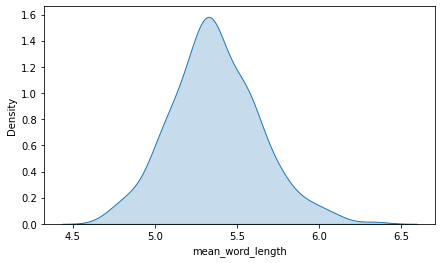

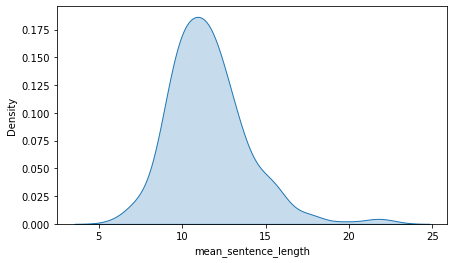

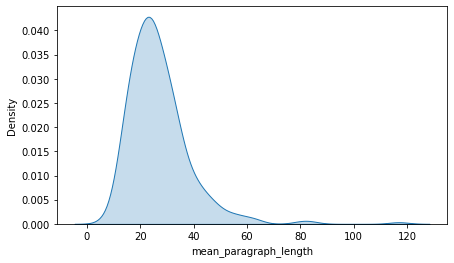

In [18]:
print('Распределения значений базовых характеристик текста:')
for key in ['mean_word_length', 'mean_sentence_length', 'mean_paragraph_length']:
    plt.figure(figsize = (7, 4))
    sns.kdeplot(data = len_set[key], label = key, shade = True)
    plt.show()

Как видно из графиков, значения базовых характеристик преимущественно лежат в довольно узком интервале (относительно всего диапазона значений для этих величин), хотя для средних длин предложений и абзацев заметны небольшие выбросы.
Проверим, есть ли корреляция между базовыми показателями и оценочными показателями текстов.

<AxesSubplot:>

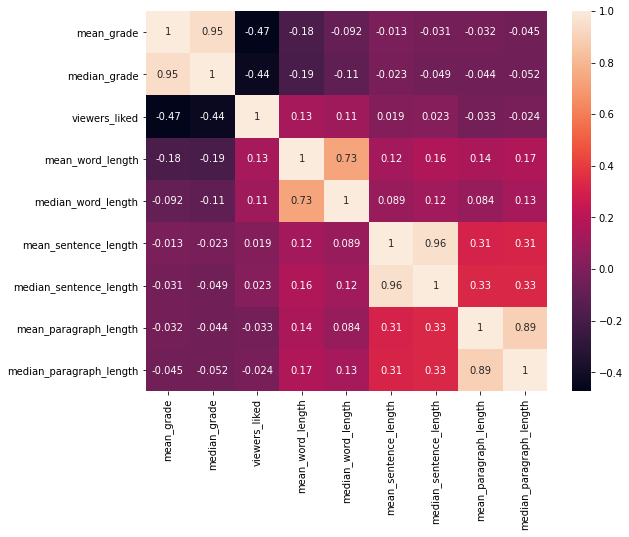

In [19]:
plt.figure(figsize = (9, 7))
sns.heatmap(len_set.corr(), annot = True)

Заметной корелляции между оценочными и основными размерными характеристиками текста нет. Попробуем предсказать оценку текста на основе его базовых характеристик. Для предсказания будем использовать RandomForestRegressor.

In [20]:
features = ['mean_word_length', 'median_word_length', 'mean_sentence_length', 
            'median_sentence_length', 'mean_paragraph_length', 'median_paragraph_length']
X = len_set[features]
y = len_set['viewers_liked']

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)

liking_model = RandomForestRegressor(random_state = 1)
liking_model.fit(train_X, train_y)
like_preds = liking_model.predict(val_X)
print(len_set['viewers_liked'].describe())
MAE = mean_absolute_error(val_y, like_preds)
print('Средняя ошибка: ', MAE)
print('Соотношение ошибки к интервалу исследуемых величин: ', MAE / (len_set['viewers_liked'].max() - len_set['viewers_liked'].min()))
print(len_set[len_set['viewers_liked'] < MAE]['viewers_liked'].count())


count    295.000000
mean       2.303484
std        0.938132
min        0.285442
25%        1.627492
50%        2.247191
75%        2.833435
max        5.555556
Name: viewers_liked, dtype: float64
Средняя ошибка:  0.7486783421488488
Соотношение ошибки к интервалу исследуемых величин:  0.1420611522243924
6


Точность предсказаний довольно низкая, минимальные значения процента лайков даже меньше чем величина средней ошибки для предсказанных величин.

In [21]:
X = len_set[features]
y = len_set['mean_grade']

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)

rating_model = RandomForestRegressor(random_state = 1)
rating_model.fit(train_X, train_y)
like_preds = rating_model.predict(val_X)
print(len_set['mean_grade'].describe())
MAE = mean_absolute_error(val_y, like_preds)
print('Средняя ошибка: ', MAE)
print('Соотношение ошибки к интервалу исследуемых величин: ', MAE / (len_set['mean_grade'].max() - len_set['mean_grade'].min()))

count    295.000000
mean       6.175433
std        1.441815
min        2.761905
25%        5.181818
50%        6.090909
75%        7.213636
max       10.400000
Name: mean_grade, dtype: float64
Средняя ошибка:  1.0959033505908502
Соотношение ошибки к интервалу исследуемых величин:  0.14347861821950034


Точность предсказаний довольно низкая, минимальные значения процента лайков даже меньше чем величина средней ошибки для предсказанных величин. 
#### Рассмотрим характеристики текста, основанные на частотности частей речи.
Сперва определим функции для подсчета частей речи, а также определения содержания стоп-слов (семи-семантических, т.е. не имеющих собственного значения вне контекста).

In [22]:
morph = MorphAnalyzer()

#Базовая функция для получения объекта OpencorporaTag из блиблиотеки pymorphy2 для заданного слова
def word_data(word):
    all_data = morph.parse(word)
    selected_tag = sorted(all_data, key = lambda data: data.score, reverse = True)[0]
    return selected_tag

#Функция для присвоения слову рейтинга в соответствии с его приблизительной семантической значимостью
def word_rank(word):
    word_rank = 6
    ranks = [{'rank': 1, 'forms': {'NOUN': 'nomn', 'NPRO': 'nomn', 'VERB': '', 'INFN': ''}},
            {'rank': 2, 'forms': {'NOUN': '', 'NPRO': '', 'PRTF': '', 'PRTS': '', 'GRND': ''}},
            {'rank': 3, 'forms': {'ADJF': '', 'ADJS': '', 'ADVB': '', 'PRED': ''}},
            {'rank': 4, 'forms': {'COMP': '', 'NUMR': ''}},
            {'rank': 5, 'forms': {'PREP': '', 'CONJ': '', 'PRCL': ''}},
            {'rank': 6, 'forms': {'INTJ': ''}}]
    description = word_data(word)
    for rank in ranks:
        for key in rank['forms']:
            if key in description.tag and rank['forms'][key] and rank['forms'][key] in description.tag:
                word_rank = rank['rank']
                break
            elif key in description.tag and not rank['forms'][key]:
                word_rank = rank['rank']
                break
    return word_rank

#Функция для вычесления доли стоп-слов среди заданных слов
def non_semantic_ratio(words):
    non_semantic = 0
    for word in words:
        if word_rank(word) >= 4:
            non_semantic += 1 
    return non_semantic / len(words)

#Функция для вычисления ipm для каждой части речи, обнаруженной среди заданных слов
def count_POS(words):
    keys = ['ADJF', 'ADJS', 'ADVB', 'COMP', 'CONJ', 'GRND', 'INFN', 'INTJ', 'NOUN', 'NPRO', 
            'NUMR', 'PRCL', 'PRED', 'PREP', 'PRTF', 'PRTS', 'VERB']
    POS_count = dict.fromkeys(keys, 0)
    for word in words:
        oc_tag = word_data(word)
        key = oc_tag.tag.POS
        if key in keys:
            POS_count[key] += 1
    total = len(words)
    for key in POS_count:
        POS_count[key] = round((POS_count[key] / total) * 1000000, 3)
    return list(POS_count.values())

#Функция для получения списка слов из заданного текста
def text2words(text):
    if isinstance(text, list):
        sentences = cut2sent(' '.join(text))
    else:
        sentences = cut2sent(text)
    words = []
    for sentence in sentences:
        words.extend(cut2words(sentence))
    return words

Обработка большого количества текстов с помощью pymophy2 занимает довольно продолжительное время, поэтому мы соберем эти данные в отдельный датафрейм и сохраним его, чтобы не потребовалось выполнять эти вычисления заново.

In [23]:
#linguo_data = dataset[['mean_grade', 'median_grade', 'viewers_liked', 'text']].copy()
#linguo_data['stop_words_ratio'] = linguo_data['text'].apply(lambda x: non_semantic_ratio(text2words(x)))
#linguo_data['POS_vector'] = linguo_data['text'].apply(lambda x: count_POS(text2words(x)))
#linguo_data.to_json('linguo_data.json')

linguo_data = pd.read_json('linguo_data.json')

In [24]:
linguo_data.head()

,mean_grade,median_grade,viewers_liked,text,stop_words_ratio,POS_vector
0,5.363636,4.0,2.824859,"[На часах 14:15, - Сеть пропала, - цокнула язы...",0.228182,"[98110.061, 10839.355, 45858.81, 2223.457, 675..."
1,6.863636,7.0,2.272727,"[Парящая: Небесный патруль, Мне всегда было ин...",0.254068,"[116471.596, 7422.21, 63659.72, 3996.574, 8621..."
2,9.272727,10.0,0.285442,"[Код Манны, «Неудачница», «Бездарная», «Уродин...",0.276145,"[102568.069, 9591.584, 54146.04, 5414.604, 108..."
3,5.454545,5.0,1.881188,"[Спасение, Фантастический рассказ ""Спасение"", ...",0.264048,"[96072.508, 10574.018, 71299.094, 5135.952, 10..."
4,5.200000,5.5,2.442529,"[Маг по особым поручениям, – Ваши документы, м...",0.243482,"[126997.477, 5466.779, 57611.438, 5046.257, 92..."


Поскольку векторы сложнее визуализировать, мы используем другой параметр, а именно сходство каждого вектора с вектором, являющимся средним для всех данных текстов. В качестве меры сходства используем косинусный коэффициент.

In [25]:
def cosine_similarity(a, b):
    return np.dot(a, b)/np.sqrt(a.dot(a)*b.dot(b))

#Векторы частей речи были сформированы как списки значений, поэтому для дальнейшей обработки их нужно 
#преобразовать в массивы numpy

linguo_data['np_vector'] = linguo_data['POS_vector'].apply(lambda x: np.array(x))
mean_vector = np.mean(linguo_data['np_vector'])

In [26]:
linguo_data['np_vector'][3]

array([ 96072.508,  10574.018,  71299.094,   5135.952, 103927.492,
         7552.87 ,  34138.973,   3927.492, 222658.61 , 123564.955,
         3021.148,  55891.239,   9063.444,  90634.441,   5438.066,
         1812.689, 153776.435])

In [27]:
linguo_data['cosine_similarity'] = linguo_data['np_vector'].apply(lambda x: cosine_similarity(mean_vector, x))

Проверим, есть ли корреляция между оценочными показателями текстов и характеристиками, основанными на представленности частей речи:

<AxesSubplot:>

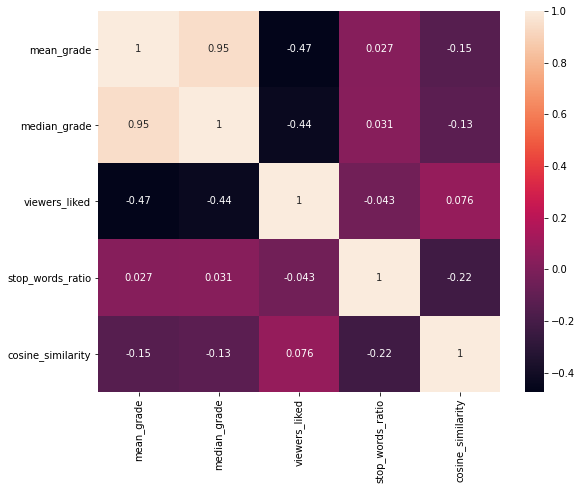

In [28]:
plt.figure(figsize = (9, 7))
sns.heatmap(linguo_data.corr(), annot = True)

Значительных корреляций нет. Интересно, что наблюдается небольшая негативная корреляция между долей стоп-слов в тексте и косинусным коэффициентом. Это может объясняться тем, что усредненный вектор частей речи соответствует такому их распределению, при котором доля синсемантических слов (союзов, предлогов и т.п.) в тексте достаточно мала. Таким образом, тексты, вектор частотности частей речи которых отличается от среднего, содержат больше синсемантических слов.

<AxesSubplot:xlabel='stop_words_ratio', ylabel='cosine_similarity'>

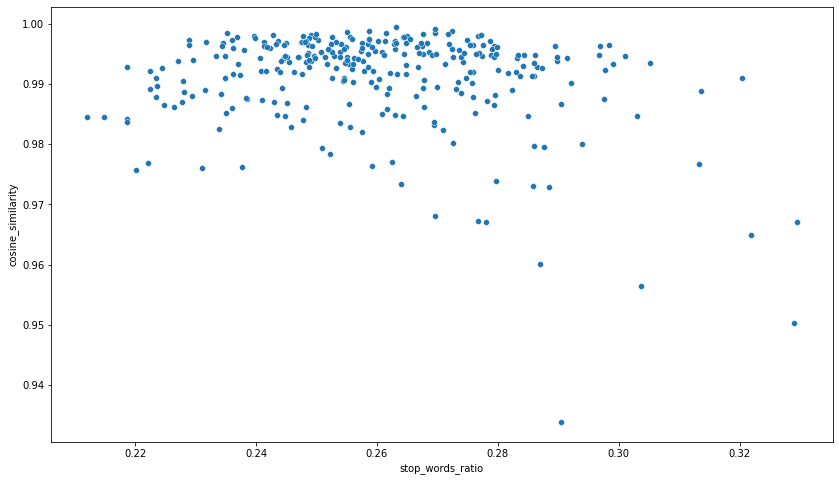

In [29]:
plt.figure(figsize = (14, 8))
sns.scatterplot(x = linguo_data['stop_words_ratio'], y = linguo_data['cosine_similarity'])

Точечная диаграмма для косинусного коэффицента и доли стоп-слов в целом подтверждает это предположение.

Посмотрим, как соотносятся распределения этих показателей с распределением оценок жюри и процента лайков.

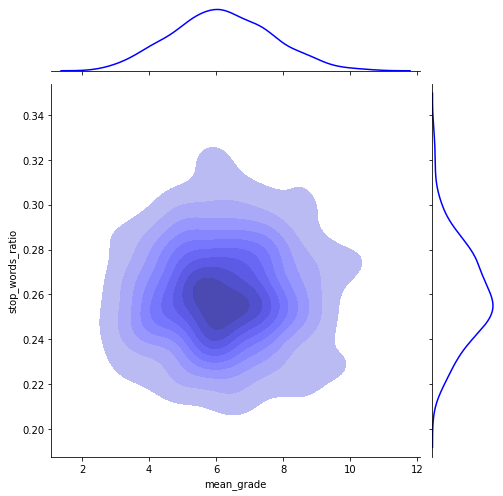

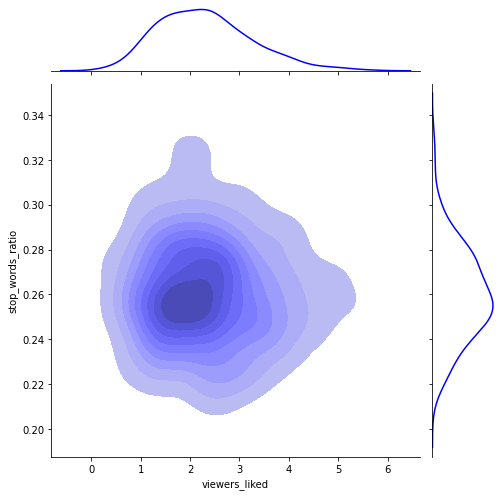

In [30]:
sns.jointplot(x = linguo_data['mean_grade'], y = linguo_data['stop_words_ratio'], height = 7, color = 'b', 
              shade = True, kind = 'kde')
sns.jointplot(x = linguo_data['viewers_liked'], y = linguo_data['stop_words_ratio'], height = 7, color = 'b', 
              shade = True, kind = 'kde')

Может показаться, что тексты с меньшей долей стоп-слов имеют меньший процент лайков аудиории, но это вероятно связано с тем, что тексты с меньшей долей стоп-слов и меньшим процентом лайков просто преобладают в выборке.

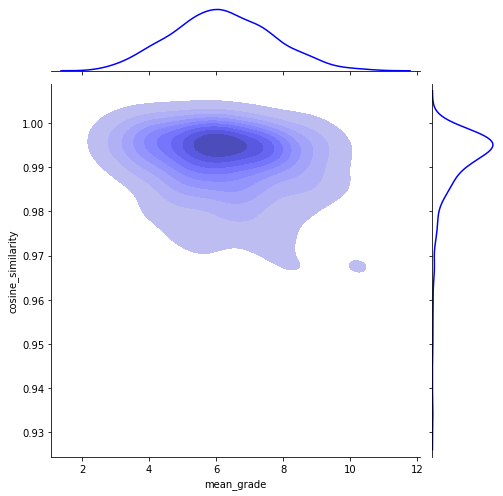

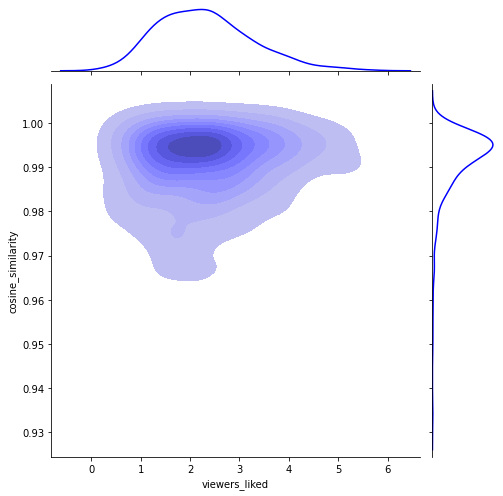

In [31]:
sns.jointplot(x = linguo_data['mean_grade'], y = linguo_data['cosine_similarity'], height = 7, color = 'b', 
              shade = True, kind = 'kde')
sns.jointplot(x = linguo_data['viewers_liked'], y = linguo_data['cosine_similarity'], height = 7, color = 'b', 
              shade = True, kind = 'kde')

In [32]:
#Попробуем получить предсказания процента лайков на основе доли стоп-слов и косинусного коэффициента
features = ['stop_words_ratio', 'cosine_similarity']
X = linguo_data[features]
y = linguo_data['viewers_liked']

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)

linguo_model = RandomForestRegressor(random_state = 1)
linguo_model.fit(train_X, train_y)
like_preds = linguo_model.predict(val_X)
print(linguo_data['viewers_liked'].describe())
MAE = mean_absolute_error(val_y, like_preds)
print('Средняя ошибка: ', MAE)
print('Соотношение ошибки к интервалу исследуемых величин: ', MAE / (linguo_data['viewers_liked'].max() - linguo_data['viewers_liked'].min()))

count    295.000000
mean       2.303484
std        0.938132
min        0.285442
25%        1.627492
50%        2.247191
75%        2.833435
max        5.555556
Name: viewers_liked, dtype: float64
Средняя ошибка:  0.8023383179449052
Соотношение ошибки к интервалу исследуемых величин:  0.15224309226503924


In [33]:
#Предсказания для оценок жюри
features = ['stop_words_ratio', 'cosine_similarity']
X = linguo_data[features]
y = linguo_data['mean_grade']

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)

linguo_model = RandomForestRegressor(random_state = 1)
linguo_model.fit(train_X, train_y)
rating_preds = linguo_model.predict(val_X)
print(linguo_data['mean_grade'].describe())
MAE = mean_absolute_error(val_y, rating_preds)
print('Средняя ошибка: ', MAE)
print('Соотношение ошибки к интервалу исследуемых величин: ', MAE / (linguo_data['mean_grade'].max() - linguo_data['mean_grade'].min()))

count    295.000000
mean       6.175433
std        1.441815
min        2.761905
25%        5.181818
50%        6.090909
75%        7.213636
max       10.400000
Name: mean_grade, dtype: float64
Средняя ошибка:  1.4073466567187565
Соотношение ошибки к интервалу исследуемых величин:  0.1842536146575777


Точность предсказаний в данном случае оказалась даже ниже.

#### Попробуем взять частотность каждой части речи в тексте как отдельный фактор. 
Для этого создадим новый датафрейм на основе имеющегося датафрейма с векторами частей речи.

In [34]:
keys = ['ADJF', 'ADJS', 'ADVB', 'COMP', 'CONJ', 'GRND', 'INFN', 'INTJ', 'NOUN', 'NPRO', 
            'NUMR', 'PRCL', 'PRED', 'PREP', 'PRTF', 'PRTS', 'VERB']
POS_set = linguo_data[['mean_grade', 'viewers_liked', 'POS_vector']].copy()
for key in keys:
    POS_set[key] = POS_set['POS_vector'].apply(lambda x: x[keys.index(key)])
POS_set.drop(columns = ['POS_vector'], inplace = True)
POS_set.describe()

,mean_grade,viewers_liked,ADJF,ADJS,ADVB,COMP,CONJ,GRND,INFN,INTJ,NOUN,NPRO,NUMR,PRCL,PRED,PREP,PRTF,PRTS,VERB
count,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000
mean,6.175433,2.303484,104834.603214,9171.794163,64967.012071,4858.172736,91893.837017,16009.423722,27865.612264,2143.723363,285252.296586,68340.357803,5231.121454,46507.539241,4271.248227,105152.960610,13141.322559,2453.989986,143479.193051
std,1.441815,0.938132,16091.985805,2758.504436,12282.531238,1799.430387,14377.942576,7637.029579,6142.225939,1501.957430,33461.926663,21462.405784,2888.880042,11802.659567,1898.781093,10292.491466,6184.828884,1497.109858,18232.351987
min,2.761905,0.285442,66165.414000,3069.839000,35890.218000,703.730000,59116.809000,203.046000,9581.541000,0.000000,172318.126000,21223.471000,525.210000,20418.987000,392.465000,77676.240000,2402.402000,0.000000,92403.376000
25%,5.181818,1.627492,93178.454500,7389.320500,56972.049000,3616.694000,81576.992500,10518.656000,24273.395000,1118.471000,264794.945000,51812.816000,3103.663500,37977.518500,2974.080500,98326.871000,8591.632000,1398.116500,129961.226000
50%,6.090909,2.247191,104327.527000,8902.077000,63798.220000,4732.608000,91538.842000,14903.130000,27753.535000,1797.973000,286317.058000,66666.667000,4587.156000,46267.432000,3980.892000,105154.251000,12023.001000,2252.252000,144824.311000
75%,7.213636,2.833435,115580.920500,10582.123500,72737.240500,5815.480500,102026.018000,20699.826500,31634.663000,2841.505500,307124.541500,79982.185000,6697.510000,53423.657000,5426.708000,112347.993500,16761.934500,3221.575000,155778.675000
max,10.400000,5.555556,159106.769000,20337.302000,104309.426000,11814.658000,136852.792000,47038.659000,46085.859000,9460.738000,365971.108000,136194.030000,15603.167000,95137.421000,12658.228000,137691.238000,37389.649000,9492.169000,202453.988000


In [35]:
#Предсказания для процента лайков
X = POS_set[keys]
y = POS_set['viewers_liked']

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)

POS_model = RandomForestRegressor(random_state = 1)
POS_model.fit(train_X, train_y)
like_preds = POS_model.predict(val_X)
print(POS_set['viewers_liked'].describe())
MAE = mean_absolute_error(val_y, like_preds)
print('Средняя ошибка: ', MAE)
print('Соотношение ошибки к интервалу исследуемых величин: ', MAE / (POS_set['viewers_liked'].max() - POS_set['viewers_liked'].min()))

count    295.000000
mean       2.303484
std        0.938132
min        0.285442
25%        1.627492
50%        2.247191
75%        2.833435
max        5.555556
Name: viewers_liked, dtype: float64
Средняя ошибка:  0.613168952918892
Соотношение ошибки к интервалу исследуемых величин:  0.11634834755542432


In [36]:
#Предсказания для процента лайков
X = POS_set[keys]
y = POS_set['mean_grade']

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)

POS_model = RandomForestRegressor(random_state = 1)
POS_model.fit(train_X, train_y)
like_preds = POS_model.predict(val_X)
print(POS_set['mean_grade'].describe())
MAE = mean_absolute_error(val_y, like_preds)
print('Средняя ошибка: ', MAE)
print('Соотношение ошибки к интервалу исследуемых величин: ', MAE / (POS_set['mean_grade'].max() - POS_set['mean_grade'].min()))

count    295.000000
mean       6.175433
std        1.441815
min        2.761905
25%        5.181818
50%        6.090909
75%        7.213636
max       10.400000
Name: mean_grade, dtype: float64
Средняя ошибка:  1.0439443298787296
Соотношение ошибки к интервалу исследуемых величин:  0.13667600328827714


Точность предсказаний остается низкой, однако наибольшей среди использованных подходов.

#### Предварительный вывод:
Такие характеристики текста, как средняя величина слов, предложений и абзацев, по-видимому не оказывают значительного влияния на восприятие текста в целом. Чуть большее значение имеет частотность употребления автором различных частей речи, однако и одного этого параметра недостаточно, чтобы уверенно прогнозировать реакцию аудитории.